# Dense Associative Meomry

Dense Associative Memory(DAM)はエネルギー関数
$$E=-F(\sigma_i\xi_i^\mu)$$

で表される関数を減少させる方向に$\sigma$を更新させていく．

このとき，DAMを構成するユニットの状態更新則は以下のように表すことができる．
$$\sigma_i^{(t+1)}=
g\left[
    \sum_{\mu}\left(
        F\left(-\sigma_i^{t}\xi_i^\mu+\sum_{j\ne i}\sigma_j^{t}\xi_j^\mu\right)
        -F\left(\sigma_i^{t}\xi_i^\mu+\sum_{j\ne i}\sigma_j^{t}\xi_j^\mu\right)
    \right)
\right]$$

このとき，$g(x)$は離散値を扱うDAMであれば$sign$関数，連続値を扱う場合には$\tanh$関数を用いる．

## 学習方法

DAMの重み(上式の$\xi^\mu$)は以下の方法で求められる．

1. Hebb則 
2. 勾配降下法

今回の実装では，勾配降下法を用いた学習方法を行う．

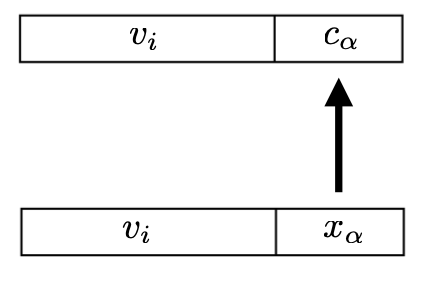

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [26]:
class DenseAssociativeMemoryClassification(nn.Module):
    def __init__(
        self,
        input_dim: int,
        n_class: int,
        epoch: int,
        random_state: False,
    ) -> None:
        super().__init__()

        self.input_dim = input_dim
        self.n_class = n_class

        self.n_unit = self.input_dim + self.n_class

        # initial state of nueron-unit
        self.v_unit = torch.empty(size=(self.input_dim, 1))
        self.x_unit = -torch.ones(size=(self.n_class, 1))

        # initial state of weight matrix
        self.weight = torch.randn(size=(self.n_unit, self.n_unit))

    def train(
        self,
        train_loader,
        n_epoch: int,
        batch_zie: int,
        optimizer: torch.optim = optim.SGD,
        loss=nn.CrossEntropyLoss,
        lr: float = 0.01,
    ):

        _loss=loss()
        _optimizer=optimizer(self.weight,lr=lr)
        

        for p_epoch in tqdm(range(n_epoch)):
            
            # train
            for data,label in train_loader:
                

            pass

    def predict(self):
        pass

    def _update_state(self):
        
        torch.tanh(
            
        )
        
        pass

## データセット

動作確認のため，とりあえずMNISTを引っ張ってくる．

In [40]:
import torchvision
import torchvision.transforms as transforms

img_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1, 1)),# reshape to (784,1)
        transforms.Lambda(lambda x: 2 * x - 1),# rescale to [-1,1]
    ]
)

train_set = torchvision.datasets.MNIST(
    root="data",
    train=True,
    transform=img_transform,
    download=True,
)

test_set = torchvision.datasets.MNIST(
    root="data",
    train=False,
    transform=img_transform,
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
)

In [41]:
# import matplotlib.pyplot as plt
# plt.imshow(train_set[0][0].reshape(28,28))
train_set[0][0].min()

tensor(-1.)

In [49]:
for v_unit, label in train_loader:
    print(f"{v_unit.shape=}")

    for i in range(10):
        Ux = -torch.ones(64, 10, 1)
        Vx = -torch.ones(64, 10, 1)
        Vx[:, i, :] *= -1

        U = torch.concatenate([v_unit, Ux], axis=1)

    print(f"{U.shape}")
    break

v_unit.shape=torch.Size([64, 784, 1])
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
torch.Size([64, 794, 1])


In [46]:
a=torch.ones(5,4,3)
b=